# Notes
Unit 3, Lesson 2.6 Challenge

Pick your own dataset, do PCA, RFE (another way to do feature selection) (sklearn.feature_selection rfe), holdout groups, cross validation.

All projects need to have this set up from now on, so Lesson 2 challenge is going to need same setup.  Need to think about the Lesson 1 necessary need to measure distance.

It is also a given that you need to understand dataset, so if you need to cleanup or alter it, do it.

# Challenge Description
Build decision tree, then match with the simplest random forest.

# Information
First data is obtained from: https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking/data
However, there isn't enough variety of columns to work with.

Second data is obtained from: https://www.kaggle.com/etiennelq/french-employment-by-town/data
This is a data on French employment, salaries, and population per town.  The focus of this dataset will be salaries.

In [112]:
import math
import warnings
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:3f}'.format

# Suppress warnings
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

# Bring in data
df = pd.read_csv("net_salary_per_town_categories.csv")
# Rename column headers to make it easier to work with
#df.columns = ['Geographic_Code', 'French_Town_Name', 'Region_Number', 'Department_Number', 'Total_Number_Firms', 'Null_Size_Firms', '1-5_Employees', '6-9_Employees', '10-19_Employees', '20-49_Employees', '50-99_Employees', '100-199_Employees', '200-499_Employees', 'Over_500_Employees']
df.columns = ['Town_Code','Town_Name','Mean_Net_Salary_MNS','Executive_MNS','Middle_Manager_MNS','Employee_MNS','Worker_MNS','Women_MNS','Feminine_Executive_MNS','Feminine_Middle_Manager_MNS','Feminine_Employee_MNS','Feminine_Worker_MNS','Men_MNS','Masculine_Executive_MNS','Masculine_Middle_Manager_MNS','Masculine_Employee_MNS','Masculine_Worker_MNS','18-25_Years_MNS','26-50_Years_MNS','>50_Years_MNS','Women_18-25_Years_MNS','Women_26-50_Years_MNS','Women_>50_Years_MNS','Men_18-25_Years_MNS','Men_26-50_Years_MNS','Men_>50_Years_MNS']
# Remove NaN values
df = df.fillna(0)

df.head()

,Town_Code,Town_Name,Mean_Net_Salary_MNS,Executive_MNS,Middle_Manager_MNS,Employee_MNS,Worker_MNS,Women_MNS,Feminine_Executive_MNS,Feminine_Middle_Manager_MNS,...,Masculine_Worker_MNS,18-25_Years_MNS,26-50_Years_MNS,>50_Years_MNS,Women_18-25_Years_MNS,Women_26-50_Years_MNS,Women_>50_Years_MNS,Men_18-25_Years_MNS,Men_26-50_Years_MNS,Men_>50_Years_MNS
0,01004,Ambérieu-en-Bugey,13.700000,24.200000,15.500000,10.300000,11.200000,11.600000,19.100000,13.200000,...,11.600000,10.500000,13.700000,16.100000,9.700000,11.800000,12.500000,11.000000,14.900000,18.600000
1,01007,Ambronay,13.500000,22.100000,14.700000,10.700000,11.400000,11.900000,19.000000,13.300000,...,11.700000,9.800000,13.800000,14.600000,9.200000,12.200000,12.500000,10.200000,14.900000,16.400000
2,01014,Arbent,13.500000,27.600000,15.600000,11.100000,11.100000,10.900000,19.500000,11.700000,...,11.800000,9.300000,13.300000,16.000000,8.900000,10.600000,12.500000,9.600000,15.100000,18.600000
3,01024,Attignat,12.900000,21.800000,14.100000,11.000000,11.300000,11.400000,19.000000,13.000000,...,11.600000,9.600000,12.900000,14.200000,9.300000,11.400000,12.200000,9.700000,13.800000,15.900000
4,01025,Bâgé-la-Ville,13.000000,22.800000,14.100000,10.500000,11.100000,11.600000,19.400000,13.600000,...,11.400000,9.400000,12.800000,15.200000,9.000000,11.800000,12.300000,9.700000,13.400000,16.900000


In [113]:
# Remove columns not to be added
#df = df.drop(columns=['Geographic_Code', 'French_Town_Name', 'Region_Number', 'Department_Number'])
df = df.drop(columns=['Town_Code','Town_Name'])

df.head()

,Mean_Net_Salary_MNS,Executive_MNS,Middle_Manager_MNS,Employee_MNS,Worker_MNS,Women_MNS,Feminine_Executive_MNS,Feminine_Middle_Manager_MNS,Feminine_Employee_MNS,Feminine_Worker_MNS,...,Masculine_Worker_MNS,18-25_Years_MNS,26-50_Years_MNS,>50_Years_MNS,Women_18-25_Years_MNS,Women_26-50_Years_MNS,Women_>50_Years_MNS,Men_18-25_Years_MNS,Men_26-50_Years_MNS,Men_>50_Years_MNS
0,13.700000,24.200000,15.500000,10.300000,11.200000,11.600000,19.100000,13.200000,10.100000,9.600000,...,11.600000,10.500000,13.700000,16.100000,9.700000,11.800000,12.500000,11.000000,14.900000,18.600000
1,13.500000,22.100000,14.700000,10.700000,11.400000,11.900000,19.000000,13.300000,10.600000,10.000000,...,11.700000,9.800000,13.800000,14.600000,9.200000,12.200000,12.500000,10.200000,14.900000,16.400000
2,13.500000,27.600000,15.600000,11.100000,11.100000,10.900000,19.500000,11.700000,10.800000,9.500000,...,11.800000,9.300000,13.300000,16.000000,8.900000,10.600000,12.500000,9.600000,15.100000,18.600000
3,12.900000,21.800000,14.100000,11.000000,11.300000,11.400000,19.000000,13.000000,10.300000,9.900000,...,11.600000,9.600000,12.900000,14.200000,9.300000,11.400000,12.200000,9.700000,13.800000,15.900000
4,13.000000,22.800000,14.100000,10.500000,11.100000,11.600000,19.400000,13.600000,10.200000,9.800000,...,11.400000,9.400000,12.800000,15.200000,9.000000,11.800000,12.300000,9.700000,13.400000,16.900000


In [114]:
df.describe() # Summary of the data

,Mean_Net_Salary_MNS,Executive_MNS,Middle_Manager_MNS,Employee_MNS,Worker_MNS,Women_MNS,Feminine_Executive_MNS,Feminine_Middle_Manager_MNS,Feminine_Employee_MNS,Feminine_Worker_MNS,...,Masculine_Worker_MNS,18-25_Years_MNS,26-50_Years_MNS,>50_Years_MNS,Women_18-25_Years_MNS,Women_26-50_Years_MNS,Women_>50_Years_MNS,Men_18-25_Years_MNS,Men_26-50_Years_MNS,Men_>50_Years_MNS
count,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,...,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000
mean,13.706386,23.703836,14.575876,10.564505,11.235650,12.038026,20.220502,13.274260,10.308879,9.827161,...,11.498189,9.549766,13.495444,15.877220,9.161565,12.055160,13.174143,9.820872,14.485981,17.679809
std,2.559329,2.836183,1.490110,0.811775,1.221755,1.787995,2.327550,0.990166,0.747563,1.104684,...,1.289598,0.997444,2.363144,3.585860,0.453023,1.825306,2.249391,1.539949,2.852490,4.530257
min,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,6.100000,...,8.900000,7.900000,9.700000,10.500000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,9.200000,...,10.800000,9.200000,12.000000,13.700000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,9.700000,...,11.300000,9.500000,12.900000,15.000000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,14.400000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,10.200000,...,11.900000,9.700000,14.300000,16.900000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,28.100000,...,53.200000,60.600000,38.100000,56.900000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


# Create Linear Regression Model

In [115]:
# Instantiate linear regression
regr = linear_model.LinearRegression()
Y = df['Mean_Net_Salary_MNS']
X = df.drop(['Mean_Net_Salary_MNS'],axis=1)
regr.fit(X, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 1.69096207e-02  2.05939816e-02  2.10092908e-02  2.81261158e-03
  4.48285255e-01 -4.13467375e-03 -9.79631745e-03 -1.91467698e-02
 -3.98326983e-04  5.53524491e-01 -1.10383104e-02 -9.39481142e-03
 -5.39835898e-03  6.51283779e-03  6.90965093e-02  5.82946275e-01
  2.13715842e-01 -3.25673113e-02 -2.65287583e-01 -9.53500358e-02
 -3.97297402e-02 -3.22503780e-01 -1.19135050e-01]

Intercept: 
 -0.03823969263372895

R-squared:
0.9996441438468145


# PCA Application Applied to Linear Regression Model

In [116]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
pca = PCA(0.90)
pca.fit(X)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)

[91.02686501  6.53048412  4.94334593]
[0.80379462 0.05766614 0.04365123]
[0.80379462 0.86146076 0.90511199]
[683.68337104 183.12300766 159.32382542]


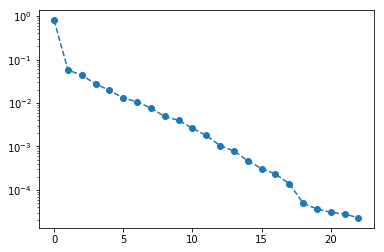

In [117]:
# Y axis says how much can be explained, where 9th variable has very small impact on predicting Property.
pca = PCA().fit(X)

plt.semilogy(pca.explained_variance_ratio_, '--o')
plt.show()

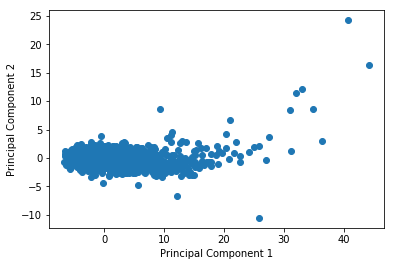

(5136, 23)
(5136, 8)
[[ 3.27282597e-01  1.51383140e+00  9.10470204e-02 ... -8.08099419e-01
  -1.12471989e+00  1.23327505e-01]
 [-1.69903379e-01  5.26741279e-01 -7.66685192e-01 ...  1.21904294e-01
  -3.77623856e-03 -1.71640624e-01]
 [ 4.75882775e-01  7.68894763e-02  1.80851194e+00 ...  1.13644308e+00
  -1.20633740e+00  1.07600260e+00]
 ...
 [-1.57999738e+00 -5.59749340e-01  2.94187555e-01 ... -2.12785077e-01
   8.57684213e-01 -1.19104676e-01]
 [-3.25260294e+00 -3.85206154e-01  1.51879276e-01 ...  7.77493943e-02
  -9.50165839e-01 -8.21385781e-01]
 [-5.05309649e+00 -1.32259820e-01  6.57337583e-01 ... -1.33668351e+00
  -4.24843020e-02 -5.47250503e-01]]


In [118]:
# Which variables/how many variables to keep
from sklearn.preprocessing import StandardScaler

# Each of 9 variables (out of 10) have different ranges.
# Standard Scalar makes it so all these different ranges makes sense.
# Standard = each number in the ranges are subtracted by the mean, and divided by standard deviation squared.
# Standard Scalar = same thing, but now the range is 0 to 1. Make everything comparable.
# Some examples are tests, intelligence levels, etc. Trying to standardize everyone.
X_std = StandardScaler().fit_transform(X)

# Pick the smallest number of Principal Components that explain 95% of the variables.
# That number is = to number of variables you should choose.
sklearn_pca = PCA(0.95)
Y_sklearn = sklearn_pca.fit_transform(X_std)

plt.scatter(Y_sklearn[:,0], Y_sklearn[:,3])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Each of the column is equal to the principal component.
# 5136 rows, 23 columns.
# 5136 rows, 8 columns.
print(X_std.shape)
print(Y_sklearn.shape)
print(Y_sklearn)

In [119]:
# Instantiate linear regression
# fitting the PCA on the X_std (reduce number of variables)
# mapping of the X_std standard scalar
X_fit = sklearn_pca.fit_transform(X_std)

regr = linear_model.LinearRegression()
regr.fit(X_fit, Y)
                    
# Check the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_fit, Y))


Coefficients: 
 [ 0.63866507 -0.06864144  0.12423889  0.00401742 -0.08022677  0.16391541
 -0.13245007 -0.27554395]

Intercept: 
 13.70638629283489

R-squared:
0.9832378117656319


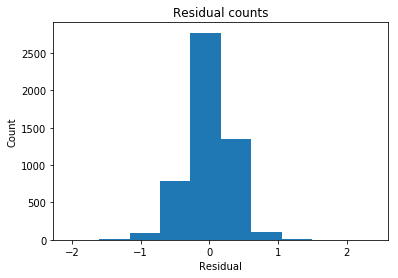

In [120]:
#### Extract predicted values.
predicted = regr.predict(X_fit).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Apply Data Splitting

In [121]:
# https://stackoverflow.com/questions/41925157/logisticregression-unknown-label-type-continuous-using-sklearn-in-python
## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
data = X_fit
target = Y
print(data.shape)
print(target.shape)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

import numpy as np
from sklearn import linear_model
from sklearn import svm

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),
    linear_model.LinearRegression()]

for item in classifiers:
    print(item)
    clf = item
    #clf.fit(trainingData, trainingScores)
    clf.fit(X_train, y_train)
    #print(clf.predict(predictionData),'\n')
    print(clf.predict(data), '\n')

(5136, 8)
(5136,)
28760
12328
3595
1541
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[13.80041807 13.55476102 13.99000553 ... 12.17414838 11.82577643
 10.90793719] 

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
[13.88436266 13.55576918 14.18833242 ... 12.46527144 11.99620544
 10.50221416] 

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)
[13.81242036 13.52147241 14.29241418 ... 12.55838482 12.05646511
 10.52625819] 

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     

C:\Users\nyejy\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[13.81264545 13.52030865 14.29061264 ... 12.56131422 12.05527735
 10.52692724] 

PassiveAggressiveRegressor(C=1.0, average=False, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive',
              max_iter=None, n_iter=None, random_state=None, shuffle=True,
              tol=None, verbose=0, warm_start=False)
[13.98469016 13.72708691 13.99909443 ... 12.38127332 11.97585751
 10.35428966] 

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)


C:\Users\nyejy\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[13.78787802 13.55336574 14.21367896 ... 12.55792433 12.07115076
 10.53455181] 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
[13.81241387 13.52148547 14.29247131 ... 12.558225   12.05681205
 10.52621441] 



In [122]:
# Use Recursive Feature Elimination
from sklearn import preprocessing
from sklearn import utils

encoder = preprocessing.LabelEncoder()
encoded = encoder.fit_transform(Y)

print(X.shape)
print(Y.shape)
print(encoded.shape)
print(X)
print(Y)
print(encoded)

(5136, 23)
(5136,)
(5136,)
      Executive_MNS  Middle_Manager_MNS  Employee_MNS  Worker_MNS  Women_MNS  \
0         24.200000           15.500000     10.300000   11.200000  11.600000   
1         22.100000           14.700000     10.700000   11.400000  11.900000   
2         27.600000           15.600000     11.100000   11.100000  10.900000   
3         21.800000           14.100000     11.000000   11.300000  11.400000   
4         22.800000           14.100000     10.500000   11.100000  11.600000   
5         22.200000           15.100000     11.000000   11.400000  12.500000   
6         24.000000           13.100000     10.500000   10.400000  10.900000   
7         23.100000           15.300000     10.900000   11.300000  12.400000   
8         21.200000           13.500000      9.900000   10.500000  10.300000   
9         23.400000           14.100000     10.300000   10.500000  11.000000   
10        27.500000           15.800000     11.800000   12.000000  14.800000   
11        25.

Automatically created module for IPython interactive environment


C:\Users\nyejy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Optimal number of features : 4


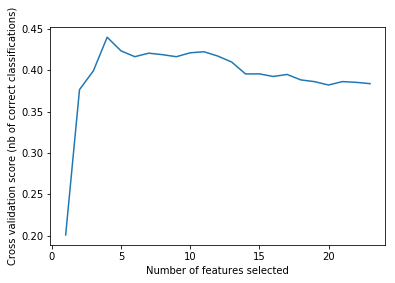

In [123]:
# http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                           n_redundant=2, n_repeated=0, n_classes=8,
#                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, encoded)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Apply Data Splitting 

In [124]:
## Not really sure why we ned to do data splitting (holdout) when the graph needs to be drawn.
## Holdout Groups is commonly starting at 30% of data, but 1% to 50% is okay.
data = X
target = Y
#print(data.shape)
#print(target.shape)
#print(data)
#print(target)

# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20, random_state=40)

print(X_train.size)
print(X_test.size)
print(y_train.size)
print(y_test.size)

#print(X_train.head(10))

94484
23644
4108
1028


# Create KNN Model

In [125]:
from sklearn import neighbors

# Run the knn model, this time with weights.
# instantiate learning model (k = 10)
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')

# Fit the X and Y to weighted knn regressor
knn_w.fit(X_train, y_train)

print(knn)
print(knn_w)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')


# Apply PCA to KNN
Here we are now using the training datas, the result is far less data, but the PCA applied still looks similar to the linear regression version.

In [126]:
# X is the scalar of the df data.  Standardize features by removing the mean and scaling to unit variance.
# Dataset might behave badly if the individual feature do no look like standard distributed data.

# Prepare the X and Y variable, where Y is dataframe column.
# fit_transform fits the model with X and apply dimensionality reduction on X.
pca = PCA(0.90)
pca.fit(X_train)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())
print(pca.singular_values_)

[95.25122347  7.06624814  5.03652252]
[0.80267974 0.0595471  0.04244265]
[0.80267974 0.86222684 0.90466949]
[625.45725256 170.35574875 143.8228007 ]


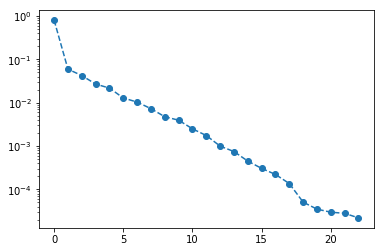

In [127]:
# Y axis says how much can be explained, where 9th variable has very small impact on predicting Property.
pca = PCA().fit(X_train)

plt.semilogy(pca.explained_variance_ratio_, '--o')
plt.show()

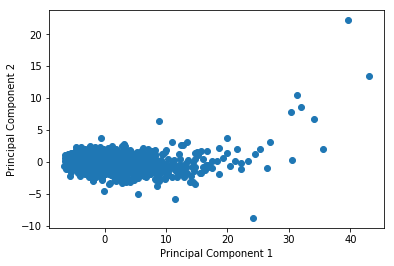

(4108, 23)
(4108, 8)
[[ 0.47422148  0.10479217 -0.84790705 ...  0.11132029  0.16312056
   0.61277539]
 [-1.87411197  0.81190141  0.66962573 ... -0.4996984   0.06858834
  -0.10133556]
 [ 0.78708837 -0.3899716  -0.51015512 ...  0.5428592  -0.95805006
   0.20141466]
 ...
 [-4.71560876  0.08518693 -0.16882459 ... -0.08623019 -0.22597677
  -0.2055014 ]
 [-1.32006953 -0.50008627 -0.92121678 ...  1.26279188  0.16638068
  -0.36842243]
 [ 0.05449538  0.16252897 -1.21119966 ... -1.9121427  -2.35734043
   1.40331014]]


In [128]:
# Which variables/how many variables to keep
from sklearn.preprocessing import StandardScaler

# Each of 9 variables (out of 10) have different ranges.
# Standard Scalar makes it so all these different ranges makes sense.
# Standard = each number in the ranges are subtracted by the mean, and divided by standard deviation squared.
# Standard Scalar = same thing, but now the range is 0 to 1. Make everything comparable.
# Some examples are tests, intelligence levels, etc. Trying to standardize everyone.
X_train_std = StandardScaler().fit_transform(X_train)

# Pick the smallest number of Principal Components that explain 95% of the variables.
# That number is = to number of variables you should choose.
sklearn_pca = PCA(0.95)
Y_train_sklearn = sklearn_pca.fit_transform(X_train_std)

plt.scatter(Y_train_sklearn[:,0], Y_train_sklearn[:,3])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Each of the column is equal to the principal component.
# 3441 rows, 21 columns.
# 3441 rows, 8 columns.
print(X_train_std.shape)
print(Y_train_sklearn.shape)
print(Y_train_sklearn)

# Apply Cross Validation Using KNN with PCA

In [129]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X_train_std, y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_train_std, y_train, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

print(score)
print(score_w)

Unweighted Accuracy: 0.98 (+/- 0.01)
Weighted Accuracy: 0.98 (+/- 0.01)
[0.97275894 0.98506086 0.97842409 0.98130284 0.9681833 ]
[0.97321688 0.98526711 0.98031206 0.98235831 0.96966637]


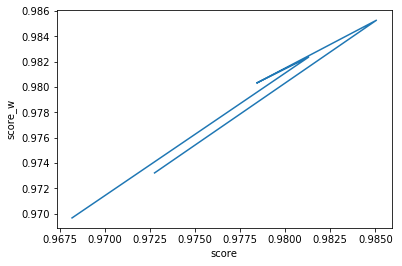

In [130]:
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/
# plot misclassification error vs k
plt.plot(score, score_w)
plt.xlabel('score')
plt.ylabel('score_w')
plt.show()

# Apply Simple Random Forest

In [131]:
#df.columns = ['Town_Code','Town_Name','Mean_Net_Salary_MNS','Executive_MNS','Middle_Manager_MNS','Employee_MNS','Worker_MNS','Women_MNS','Feminine_Executive_MNS','Feminine_Middle_Manager_MNS','Feminine_Employee_MNS','Feminine_Worker_MNS','Men_MNS','Masculine_Executive_MNS','Masculine_Middle_Manager_MNS','Masculine_Employee_MNS','Masculine_Worker_MNS','18-25_Years_MNS','26-50_Years_MNS','>50_Years_MNS','Women_18-25_Years_MNS','Women_26-50_Years_MNS','Women_>50_Years_MNS','Men_18-25_Years_MNS','Men_26-50_Years_MNS','Men_>50_Years_MNS']
#'Women_MNS','Feminine_Executive_MNS'
#'Men_MNS','Masculine_Executive_MNS'

from math import log2
#men = (df['Men_MNS']).astype(float)
#women = (df['Women_MNS']).astype(float)
#df['Men_MNS'] = df['Men_MNS'].applymap(float)
#df['Women_MNS'] = df['Women_MNS'].applymap(float)
men = df['Men_MNS'].sum()
women = df['Women_MNS'].sum()
men_exec = df['Masculine_Executive_MNS'].sum()
women_exec = df['Feminine_Executive_MNS'].sum()
men_mid = df['Masculine_Middle_Manager_MNS'].sum()
women_mid = df['Feminine_Middle_Manager_MNS'].sum()
men_emp = df['Masculine_Employee_MNS'].sum()
women_emp = df['Feminine_Employee_MNS'].sum()
men_wor = df['Masculine_Worker_MNS'].sum()
women_wor = df['Feminine_Worker_MNS'].sum()
men_not = men_mid + men_emp + men_wor
women_not = women_mid + women_emp + women_wor

# Trying to classify as male and female.
P_female = women / (women + men)
P_male = men / (women + men)

# Apply your simple random forest equation to entropy
H = P_male*log2(1/P_male) + P_female*log2(1/P_female)

# Trying to classify executives for male and females.
P_female_exec = women_exec / (women_exec + men_exec)
P_male_exec = men_exec / (women_exec + men_exec)

# Apply equation to find women who are executives
H_women_exec = P_male_exec*log2(1/P_male_exec) + P_female_exec*log2(1/P_female_exec)

# Trying to classify non executives for male and females.
P_female_not = women_not / (women_not + men_not)
P_male_not = men_not / (women_not + men_not)

# Apply equation to non executives
H_women_not = P_male_not*log2(1/P_male_not) + P_female_not*log2(1/P_female_not)

#print(men)
#print(women)
print(H)
print(H_women_exec)
print(H_women_not)

0.9921051860509902
0.9913221490013615
0.9966975078372495


# Apply Given Random Forest

In [133]:
# Applying the Random Forest 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X_train, y_train, cv=10)

ValueError: Unknown label type: 'continuous'